# 1. Problem Framing

We are a data science consultancy that has been hired by a large hotel chain to investigate viable methods of mitigating the impact of short-notice customer cancellations. The approach taken in this analysis was to look at what characteristics of an individual may indicate that they are of a high probability to cancel. If an individual is deemed likely to cancel, they are charged a higher deposit at the point of purchase. This means that some of the lost revenue due to cancellation is recovered, thus reducing the overall cost to our client. We take ethics very seriously so for obvious reasons race, religion, gender and biological sex have not been considered. All customers will pay the same overall price (if they are purchasing the same product), it is only the initial deposit (as a % of the total price) that will change on a customer to customer basis.

# 2. Importing Libraries

In [104]:
from IPython.display import display
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO 
from subprocess import call

import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier

from sklearn import tree
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')

# 2. Exploratory Data Analysis

In [105]:
df = pd.read_csv('H2.csv')

In [106]:
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


# 3. Preprocessing

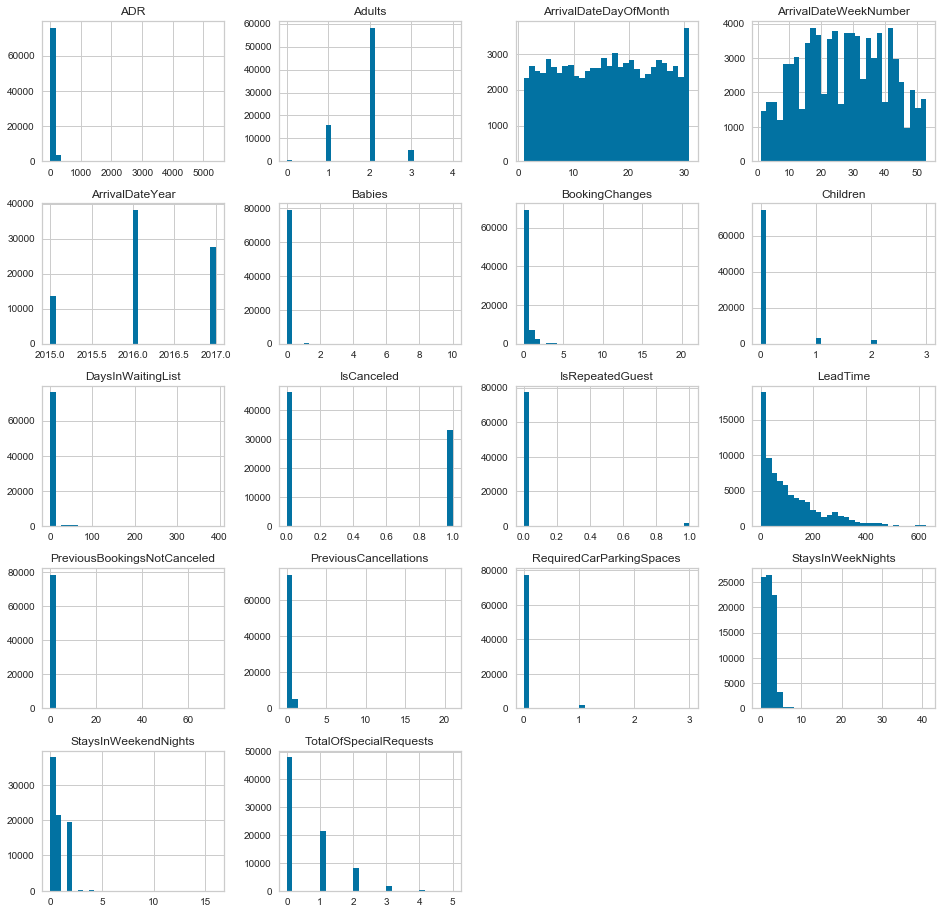

In [107]:
df.hist(bins=30, figsize=(16,16))
plt.show()

In [108]:
df.isna().sum().sum()

28

In [109]:
df = df.dropna()

In [110]:
df.isna().sum().sum()

0

In [111]:
df.reset_index(drop=True, inplace=True)

In [112]:
df.drop(columns=['ReservationStatusDate', 
                 'ReservationStatus', 
                 'ArrivalDateYear', 
                 'BookingChanges',
                 'Company',
                 'DepositType'], inplace=True)

In [113]:
y = df[['IsCanceled']]
X = df.drop(columns=['IsCanceled'])

In [114]:
num_features = ['LeadTime',
            'StaysInWeekendNights',
            'StaysInWeekNights',
            'Adults',
            'Children',
            'Babies',
            'PreviousCancellations',
            'PreviousBookingsNotCanceled',
            'DaysInWaitingList',
            'ADR',
            'RequiredCarParkingSpaces',
            'TotalOfSpecialRequests']

df_num = X[num_features]

df_cat = X.drop(columns=num_features)

cat_features = list(df_cat.columns)

In [115]:
X = pd.get_dummies(X, columns=cat_features, drop_first=True)

In [116]:
X.isnull().sum()

LeadTime                        0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        0
                               ..
Agent_        509               0
Agent_       NULL               0
CustomerType_Group              0
CustomerType_Transient          0
CustomerType_Transient-Party    0
Length: 524, dtype: int64

In [117]:
X.head()

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,DaysInWaitingList,ADR,...,Agent_ 475,Agent_ 476,Agent_ 480,Agent_ 484,Agent_ 495,Agent_ 509,Agent_ NULL,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party
0,6,0,2,1,0.0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,88,0,4,2,0.0,0,0,0,0,76.5,...,0,0,0,0,0,0,0,0,1,0
2,65,0,4,1,0.0,0,0,0,0,68.0,...,0,0,0,0,0,0,0,0,1,0
3,92,2,4,2,0.0,0,0,0,0,76.5,...,0,0,0,0,0,0,0,0,1,0
4,100,0,2,2,0.0,0,0,0,0,76.5,...,0,0,0,0,0,0,0,0,1,0


# 4. Modelling

## 4.2. Scaling

In [118]:
X_2 = X.drop(columns=num_features)

In [119]:
scaler = StandardScaler()
X_s = pd.DataFrame(scaler.fit_transform(X[num_features]))

In [120]:
X_s.columns = num_features

In [121]:
X_s = pd.concat([X_s, X_2], axis=1)

In [122]:
X_s.head()

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,DaysInWaitingList,ADR,...,Agent_ 475,Agent_ 476,Agent_ 480,Agent_ 484,Agent_ 495,Agent_ 509,Agent_ NULL,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party
0,-0.934996,-0.898710,-0.125608,-1.672123,-0.245542,-0.058611,-0.191969,-0.078183,-0.154635,-2.416280,...,0,0,0,0,0,0,0,0,1,0
1,-0.195941,-0.898710,1.247936,0.292478,-0.245542,-0.058611,-0.191969,-0.078183,-0.154635,-0.661304,...,0,0,0,0,0,0,0,0,1,0
2,-0.403237,-0.898710,1.247936,-1.672123,-0.245542,-0.058611,-0.191969,-0.078183,-0.154635,-0.856302,...,0,0,0,0,0,0,0,0,1,0
3,-0.159890,1.361231,1.247936,0.292478,-0.245542,-0.058611,-0.191969,-0.078183,-0.154635,-0.661304,...,0,0,0,0,0,0,0,0,1,0
4,-0.087787,-0.898710,-0.125608,0.292478,-0.245542,-0.058611,-0.191969,-0.078183,-0.154635,-0.661304,...,0,0,0,0,0,0,0,0,1,0


## 4.3. Train-Test split

In [123]:
X_train_initial, X_test, y_train_initial, y_test = train_test_split(X_s, 
                                                                    y, 
                                                                    test_size=0.25, 
                                                                    random_state=50)

In [124]:
X_train, X_val, y_train, y_val = train_test_split(X_train_initial, 
                                                  y_train_initial, 
                                                  test_size=0.25,
                                                  random_state=50)

## 4.4. Modelling Class

In [125]:
skf = StratifiedKFold(n_splits=3,random_state=50)

In [126]:
class Classification():
    
    def __init__(self, model, X_train, X_val, y_train, y_val):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.scores_table = pd.DataFrame()
        
        if self.model == 'Logistic Regression':
            self.instantiate = LogisticRegression(fit_intercept=False)
        elif self.model == 'Decision Tree':
            self.instantiate = DecisionTreeClassifier(random_state=50)
        elif self.model == 'Random Forest':
            self.instantiate = RandomForestClassifier(n_estimators=20, 
                                                          n_jobs=-1,
                                                          random_state=42)
        elif self.model == "SVM":
            self.instantiate = SVC(probability=True,
                                   random_state=50)
        
# SCORE FUNCTION -------------------------------------------------------------
        
    def scores(self, model, X_train, X_val, y_train, y_val):
        
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        
        train_auc = roc_auc_score(y_train, train_prob)
        val_auc = roc_auc_score(y_val, val_prob)
        
        self.train_auc = train_auc
        self.val_auc = val_auc
        
        self.scores_table = pd.DataFrame()
        
        self.scores_table["Model"] = [self.model]
        self.scores_table["Train AUC"] = [self.train_auc]
        self.scores_table["Validation AUC"] = [self.val_auc]
        
        return self.scores_table
    
# THRESHOLD ANNOTATION -------------------------------------------------------


    def annot(fpr,tpr,thr):
        k=0
        for i,j in zip(fpr,tpr):
            if k % 100 == 0:
                plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
            k+=1
            
# ROC PLOT FUNCTION ----------------------------------------------------------

    def roc_plot(model, X_train, X_val, y_train, y_val):
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        plt.figure(figsize=(7,7))
        for data in [[y_train, train_prob],[y_val, val_prob]]:
            fpr, tpr, thresh = roc_curve(data[0], data[1])
            plt.plot(fpr, tpr)
        Classification.annot(fpr, tpr, thresh)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('TPR (power)')
        plt.xlabel('FPR (alpha)')
        plt.legend(['train','val'])
        plt.show()
        
# GET SCORES FUNCTION --------------------------------------------------------

    def get_scores(self, param_grid, cv_type):
        reg = self.instantiate
        fit_reg = reg.fit(self.X_train, self.y_train)
        opt_model = GridSearchCV(fit_reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.X_train, self.y_train) 
        self.best_model = opt_model.best_estimator_
        self.scores = Classification.scores(self,
                                            self.best_model,
                                            self.X_train,
                                            self.X_val,
                                            self.y_train,
                                            self.y_val)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        print("The best hyperparameters are: ", self.best_params,'\n')
        self.roc_plot = Classification.roc_plot(self.best_model,
                                                self.X_train,
                                                self.X_val,
                                                self.y_train,
                                                self.y_val)
        self.y_predicted = opt_model.predict(self.X_val)
        
# OPTIMUM PLOT FUCNTION ------------------------------------------------------

    def opt_plots(self):
        
        if self.model == "Decision Tree" or self.model == "Random Forest":
            opt = pd.DataFrame(self.opt_model.cv_results_)
            cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
            params = pd.DataFrame(list(opt.params))
            opt = pd.concat([params, opt[cols]], axis=1, sort=False)
            
            plt.figure(figsize=[15,4])
            plt.subplot(121)
            sns.heatmap(pd.pivot_table(opt,
                                       index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_train_score')*100)
            plt.title('ROC_AUC - Training')
            plt.subplot(122)
            sns.heatmap(pd.pivot_table(opt,
                                       index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_test_score')*100)
            plt.title('ROC_AUC - Validation')
            
        else:
            print("This model does not have an optimum hyperparameter plot!")
        
# CONFUSION MATRIX FUNCTION --------------------------------------------------

    def conf_matrix(y_true, y_pred):
        
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        
        for i, label in enumerate(y_true):
            
            pred = y_pred[i]
            if label == 1:
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
                
        return cm
        
# DISPLAY PRETTY CONFUSION MATRIX FUNCTION -----------------------------------

    def pretty_conf_matrix(self):
        
        Classification.conf_matrix(self.y_val, self.y_predicted)
        cnf_matrix = confusion_matrix(self.y_val, self.y_predicted)
        
        plt.figure(figsize=(6,6))
        plt.imshow(cnf_matrix, cmap=plt.cm.Greens)
        
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        class_names = set(y)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar

# PLOT DECISION TREE FUCNTION ------------------------------------------------

    def plot_dtree(self):
        
        if self.model == "Decision Tree" or self.model == "Random Forest":
            
            dot_data = StringIO()
            export_graphviz(self.best_model, 
                            out_file=dot_data, 
                            filled=True,
                            rounded=True,
                            special_characters=True)
            graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
            graph.write_png(f'{self.model}.png')
            image = mpimg.imread(f'{self.model}.png')
            plt.figure(figsize=(50,50))
            plt.imshow(image)
            plt.show()
            
        else:
            
            print("This model does not have a decision tree plot!")
    
    def get_feature_importances(self):
        self.feature_importances = pd.DataFrame(self.best_model.feature_importances_,
                                                index = self.X_train.columns,
                                                columns=['importance']).sort_values('importance',ascending =False)
        return self.feature_importances
        

## 4.5. Logistic Regression

In [127]:
logistic_regression = Classification('Logistic Regression', X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Logistic Regression,0.903361,0.898656


The best hyperparameters are:  {'C': 10, 'solver': 'liblinear'} 



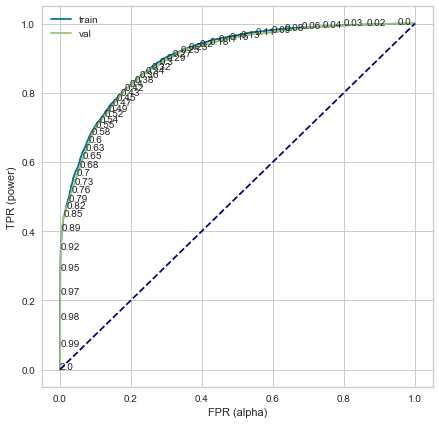

In [128]:
param_grid = {'C':[0.1,1,10,100],
              'solver':['lbfgs','liblinear','sag','saga']}
logistic_regression.get_scores(param_grid, skf)

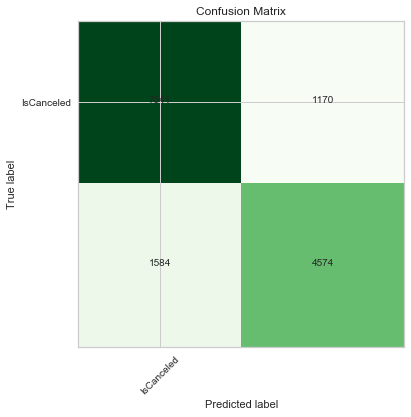

In [129]:
logistic_regression.pretty_conf_matrix()

## 4.6. Decision Trees

### 4.6.1. Iteration 1

,Model,Train AUC,Validation AUC
0,Decision Tree,0.927799,0.919023


The best hyperparameters are:  {'max_depth': 10, 'min_samples_leaf': 10} 



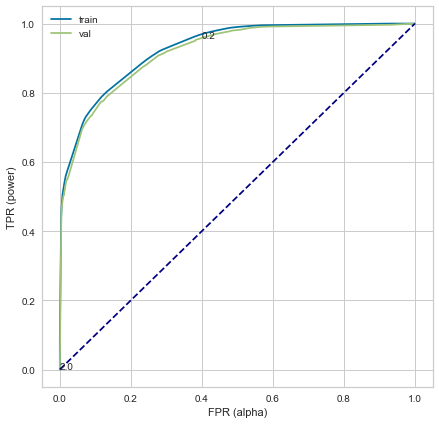

In [130]:
param_grid = {'max_depth':[10,100,500,1000], 'min_samples_leaf':[1,10,100,1000]}
decision_tree = Classification("Decision Tree", X_train, X_val, y_train, y_val)
decision_tree.get_scores(param_grid, skf)

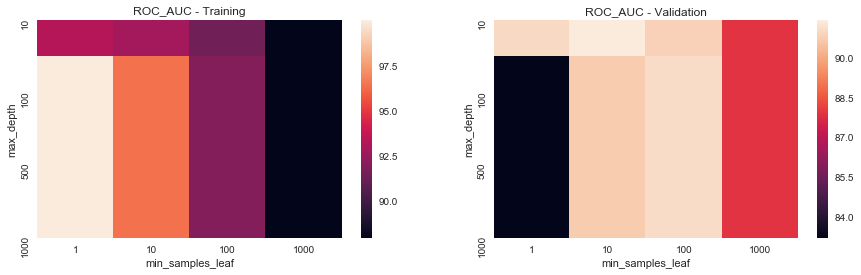

In [131]:
decision_tree.opt_plots()

### 4.6.1. Iteration 2

,Model,Train AUC,Validation AUC
0,Decision Tree,0.933974,0.921681


The best hyperparameters are:  {'max_depth': 20, 'min_samples_leaf': 50} 



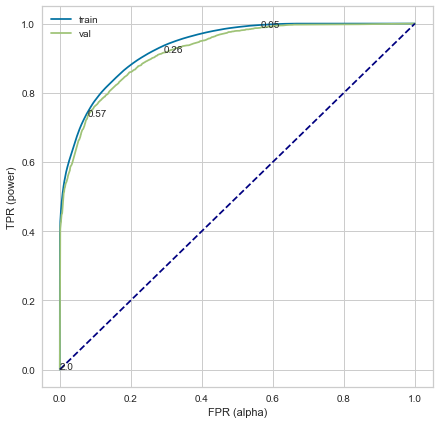

In [132]:
param_grid = {'max_depth':range(10,150,10), 'min_samples_leaf':range(50,150,10)}
decision_tree = Classification("Decision Tree", X_train, X_val, y_train, y_val)
decision_tree.get_scores(param_grid, skf)

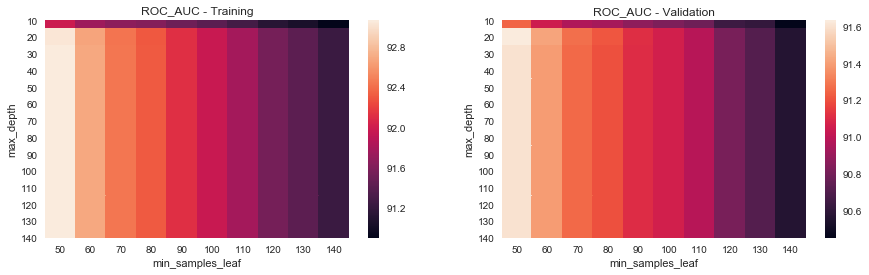

In [133]:
decision_tree.opt_plots()

### 4.6.1. Iteration 3

,Model,Train AUC,Validation AUC
0,Decision Tree,0.936956,0.923146


The best hyperparameters are:  {'max_depth': 18, 'min_samples_leaf': 40} 



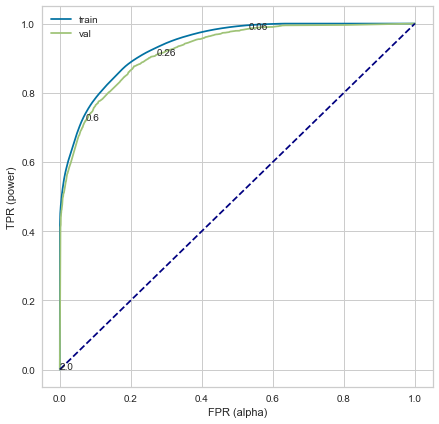

In [134]:
param_grid = {'max_depth':range(15,25,1), 'min_samples_leaf':range(10,60,10)}
decision_tree = Classification("Decision Tree", X_train, X_val, y_train, y_val)
decision_tree.get_scores(param_grid, skf)

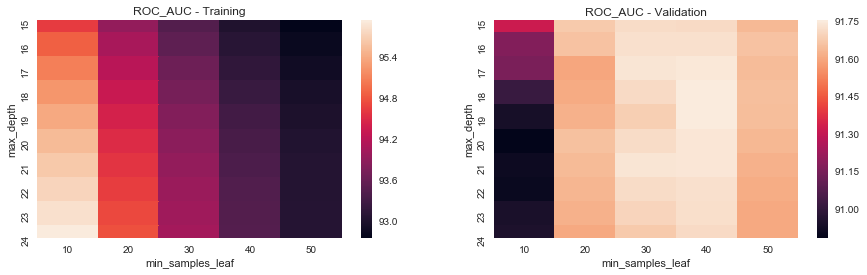

In [135]:
decision_tree.opt_plots()

### 4.6.1. Iteration 4

,Model,Train AUC,Validation AUC
0,Decision Tree,0.937282,0.923006


The best hyperparameters are:  {'max_depth': 19, 'min_samples_leaf': 41} 



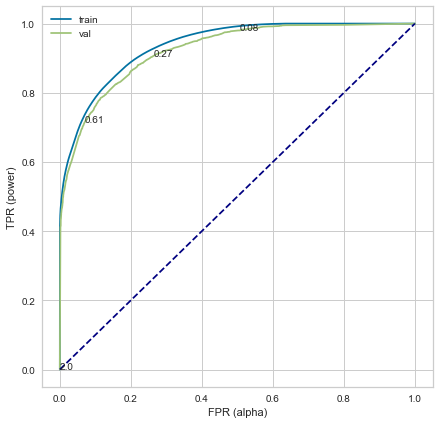

In [180]:
param_grid = {'max_depth':range(16,21,1), 'min_samples_leaf':range(35,45,1)}
decision_tree = Classification("Decision Tree", X_train, X_val, y_train, y_val)
decision_tree.get_scores(param_grid, skf)

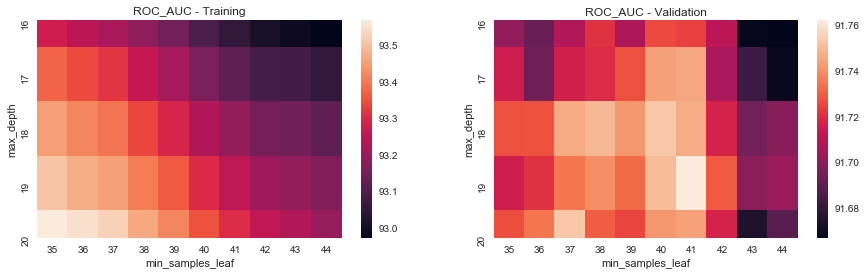

In [181]:
decision_tree.opt_plots()

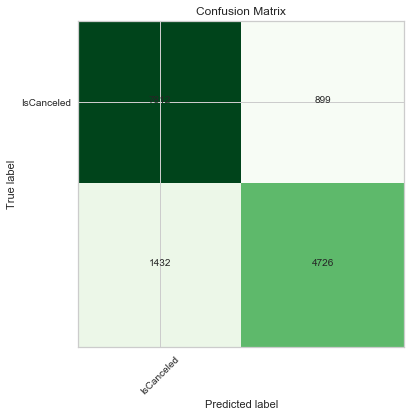

In [182]:
decision_tree.pretty_conf_matrix()

## 4.7. Random Forest

### 4.7.1. Iteration 1

,Model,Train AUC,Validation AUC
0,Random Forest,0.999411,0.946462


The best hyperparameters are:  {'max_depth': 100, 'min_samples_leaf': 1} 



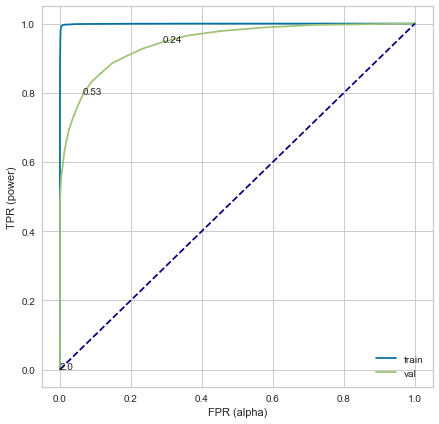

In [183]:
param_grid = {'max_depth':[10,100,500,1000], 'min_samples_leaf':[1,10,100,1000]}
random_forest = Classification("Random Forest", X_train, X_val, y_train, y_val)
random_forest.get_scores(param_grid, skf)

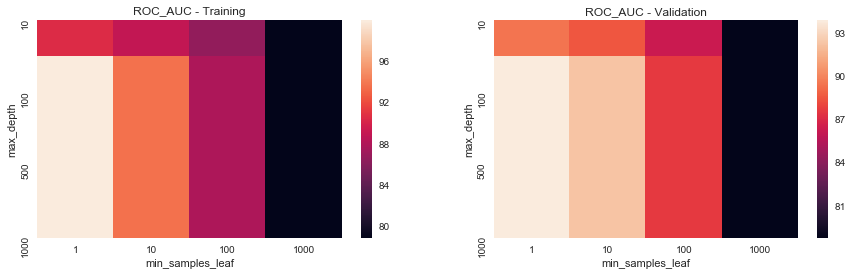

In [184]:
random_forest.opt_plots()

### 4.7.2. Iteration 2

,Model,Train AUC,Validation AUC
0,Random Forest,0.998293,0.947042


The best hyperparameters are:  {'max_depth': 50, 'min_samples_leaf': 1} 



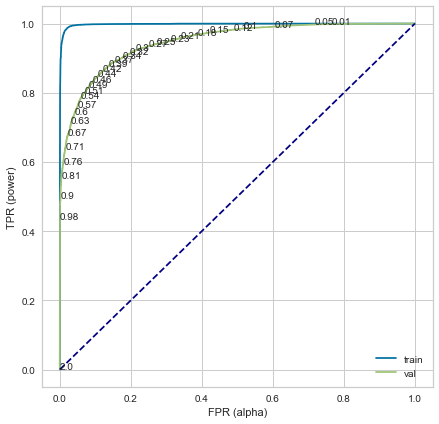

In [185]:
param_grid = {'max_depth':range(50,150,10), 'min_samples_leaf':range(1,10,1)}
random_forest = Classification("Random Forest", X_train, X_val, y_train, y_val)
random_forest.get_scores(param_grid, skf)

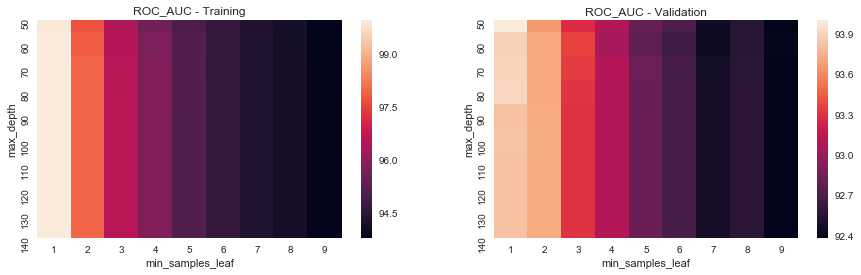

In [186]:
random_forest.opt_plots()

### 4.7.3. Iteration 3

,Model,Train AUC,Validation AUC
0,Random Forest,0.998293,0.947042


The best hyperparameters are:  {'max_depth': 50, 'min_samples_leaf': 1} 



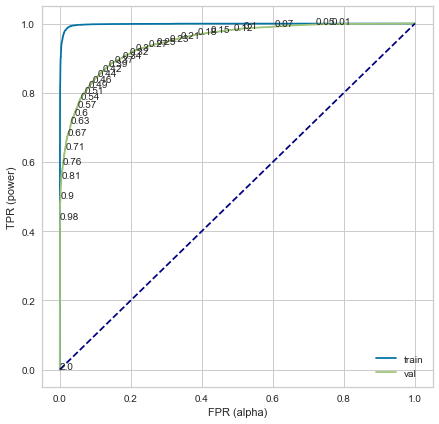

In [187]:
param_grid = {'max_depth':range(10,60,1), 'min_samples_leaf':range(1,3,1)}
random_forest = Classification("Random Forest", X_train, X_val, y_train, y_val)
random_forest.get_scores(param_grid, skf)

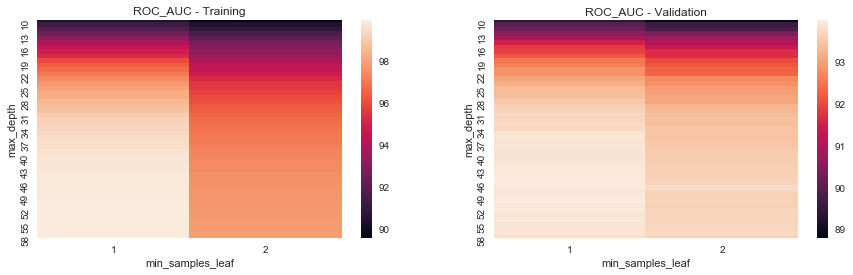

In [188]:
random_forest.opt_plots()

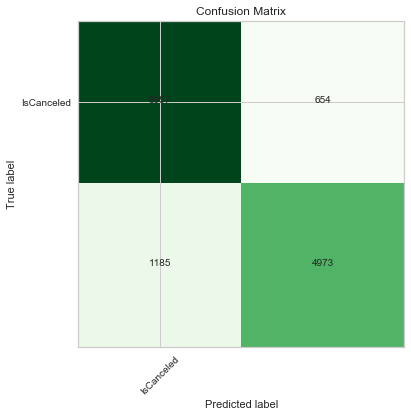

In [189]:
random_forest.pretty_conf_matrix()

# Ensemble Methods

In [190]:
class Ensemble(Classification):
    
    def __init__(self, ensemble_method, estimators, X_train, X_val, y_train, y_val):
        
        self.ensemble_method = ensemble_method
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        
        if self.ensemble_method == "Voting":
            self.instantiate = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
        elif self.ensemble_method == "AdaBoost":
            self.instantiate = AdaBoostClassifier(estimators, algorithm='SAMME', n_estimators=20)
        elif self.ensemble_method == "XGBoost":
            self.instantiate = XGBClassifier(n_jobs=-1)
        elif self.ensemble_method == "Stacking":
            self.instantiate = StackingClassifier(estimators)
            
    def ensemble_scores(self):

        train_prob = self.instantiate.predict_proba(self.X_train)[:,1]
        val_prob = self.instantiate.predict_proba(self.X_val)[:,1]

        train_auc = roc_auc_score(self.y_train, train_prob)
        val_auc = roc_auc_score(self.y_val, val_prob)

        self.train_auc = train_auc
        self.val_auc = val_auc

        self.scores_table = pd.DataFrame()

        self.scores_table["Model"] = [self.ensemble_method]
        self.scores_table["Train AUC"] = [self.train_auc]
        self.scores_table["Validation AUC"] = [self.val_auc]

        return self.scores_table
    
    def ensemble_get_scores(self, param_grid, cv_type):
        reg = self.instantiate
        fit_reg = reg.fit(self.X_train, self.y_train)
        opt_model = GridSearchCV(fit_reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.X_train, self.y_train) 
        self.best_model = opt_model.best_estimator_
        self.scores = Ensemble.ensemble_scores(self)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
#         print("The best hyperparameters are: ", self.best_params,'\n')
        self.roc_plot = Classification.roc_plot(self.best_model,
                                                self.X_train,
                                                self.X_val,
                                                self.y_train,
                                                self.y_val)
        self.y_predicted = opt_model.predict(self.X_val)
        
    def conf_matrix(y_true, y_pred):
        
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        
        for i, label in enumerate(y_true):
            
            pred = y_pred[i]
            if label == 1:
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
                
        return cm
    
    def ensemble_pretty_conf_matrix(self):
        
        Ensemble.conf_matrix(self.y_val, self.y_predicted)
        cnf_matrix = confusion_matrix(self.y_val, self.y_predicted)
        
        plt.figure(figsize=(6,6))
        plt.imshow(cnf_matrix, cmap=plt.cm.Greens)
        
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        class_names = set(y)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar

## Voting Classifier

In [195]:
log_reg = ('lr', logistic_regression.best_model)
dtree = ('dt', decision_tree.best_model)
rand_forest = ('rnd', random_forest.best_model)
estimators = [log_reg, dtree, rand_forest]

In [196]:
voting = Ensemble("Voting", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Voting,0.97889,0.942302


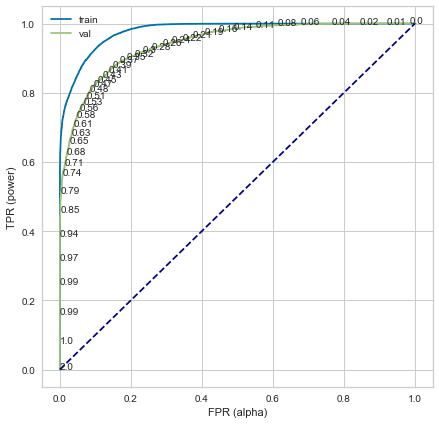

In [197]:
voting.ensemble_get_scores({}, skf)

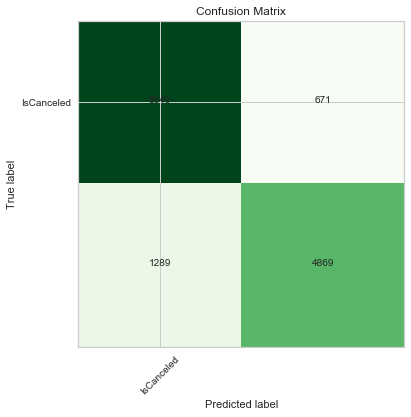

In [198]:
voting.ensemble_pretty_conf_matrix()

## AdaBoost

### AdaBoost - Logistic Regression

In [199]:
estimators = logistic_regression.best_model
adaboost1 = Ensemble("AdaBoost", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,AdaBoost,0.878522,0.874035


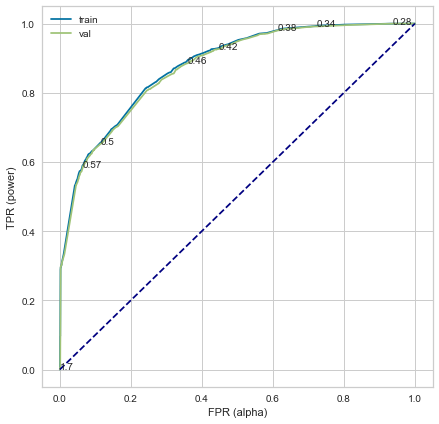

In [200]:
adaboost1.ensemble_get_scores({}, skf)

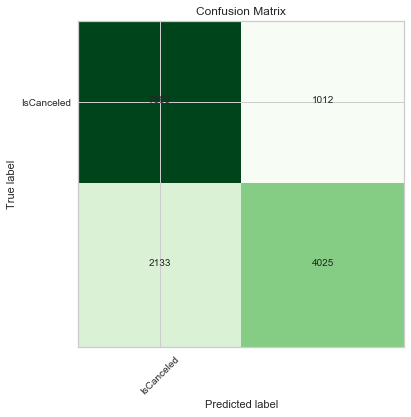

In [201]:
adaboost1.ensemble_pretty_conf_matrix()

### AdaBoost - Decision Tree

In [202]:
estimators = decision_tree.best_model
adaboost2 = Ensemble("AdaBoost", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,AdaBoost,0.980483,0.932091


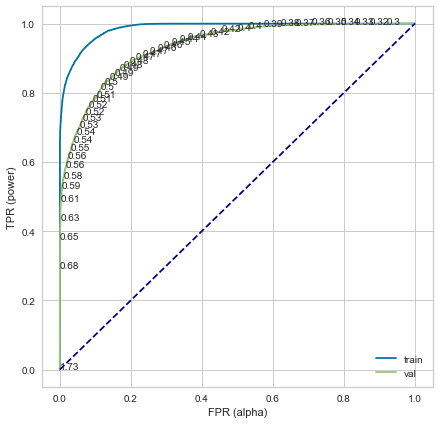

In [203]:
adaboost2.ensemble_get_scores({}, skf)

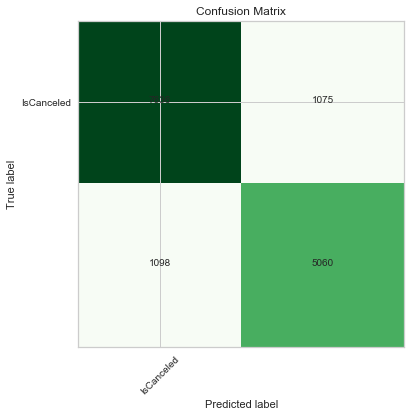

In [204]:
adaboost2.ensemble_pretty_conf_matrix()

### AdaBoost - Random Forest

In [205]:
estimators = random_forest.best_model
adaboost3 = Ensemble("AdaBoost", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,AdaBoost,0.999942,0.932234


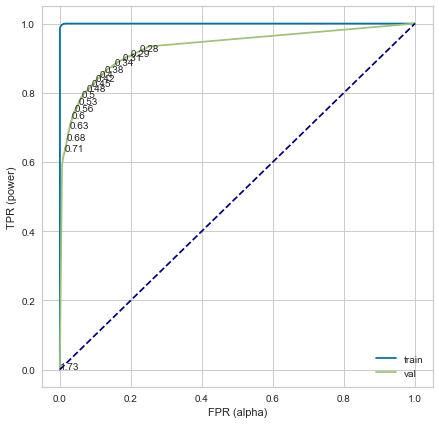

In [206]:
adaboost3.ensemble_get_scores({}, skf)

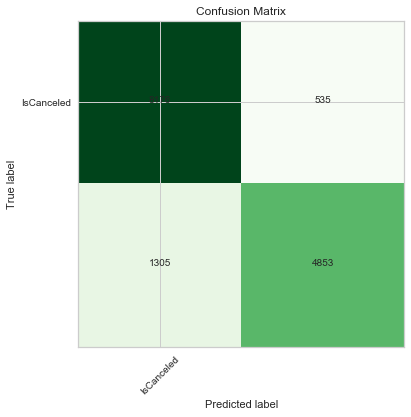

In [207]:
adaboost3.ensemble_pretty_conf_matrix()

### AdaBoost - Voting Classifier

In [208]:
estimators = voting.best_model
adaboost4 = Ensemble("AdaBoost", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,AdaBoost,0.999944,0.946011


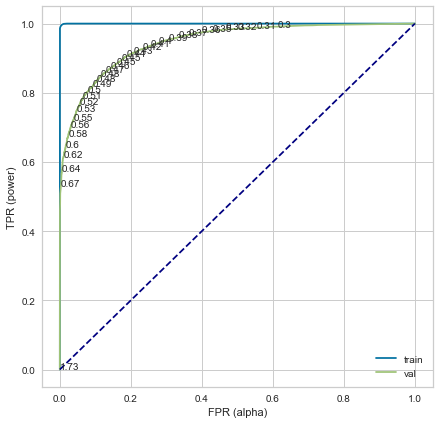

In [209]:
adaboost4.ensemble_get_scores({}, skf)

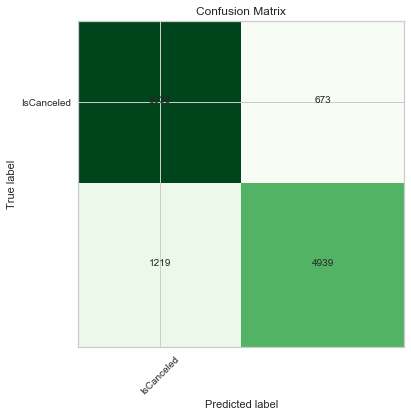

In [210]:
adaboost4.ensemble_pretty_conf_matrix()

## XGBoost

In [211]:
estimators = []
xgboost = Ensemble("XGBoost", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,XGBoost,0.920237,0.920104


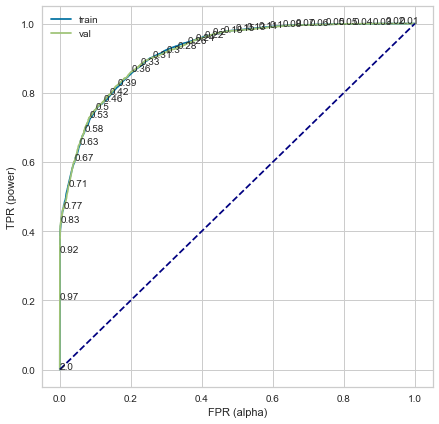

In [212]:
xgboost.ensemble_get_scores({}, skf)

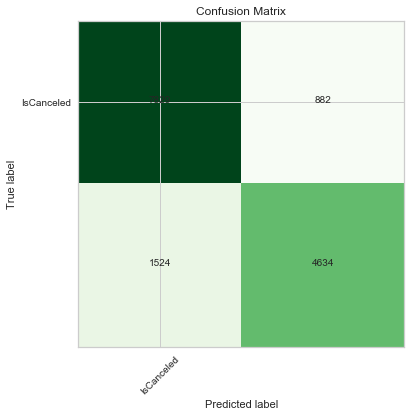

In [213]:
xgboost.ensemble_pretty_conf_matrix()

## Stacking

In [214]:
estimators = [('lr',logistic_regression.best_model), 
              ('dt', decision_tree.best_model), 
              ('rnd', random_forest.best_model)]
stacking = Ensemble("Stacking", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Stacking,0.996112,0.948935


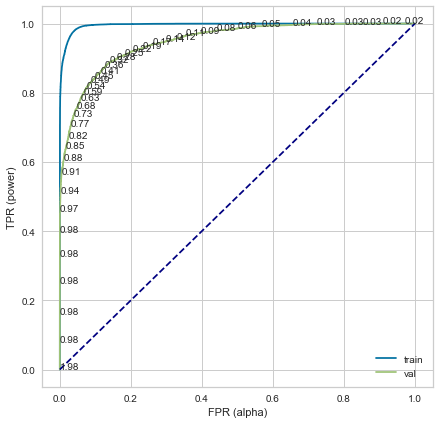

In [215]:
stacking.ensemble_get_scores({}, skf)

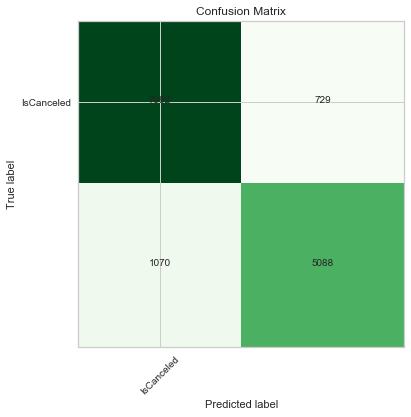

In [216]:
stacking.ensemble_pretty_conf_matrix()

## Feature Importance

In [217]:
final_model = random_forest.best_model

In [218]:
feature_importance = pd.DataFrame(final_model.feature_importances_)

In [219]:
feature_importance.rename(columns={0:'Importance'}, inplace=True)

In [220]:
feature_importance['Feature'] = X_s.columns

In [221]:
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

In [225]:
feature_importance.head(20)

,Importance,Feature
0,0.101343,LeadTime
232,0.081141,Country_PRT
11,0.074694,TotalOfSpecialRequests
9,0.060365,ADR
6,0.046779,PreviousCancellations
522,0.029017,CustomerType_Transient
2,0.027794,StaysInWeekNights
523,0.020519,CustomerType_Transient-Party
1,0.019357,StaysInWeekendNights
278,0.017951,MarketSegment_Online TA


In [223]:
top_20_features = feature_importance.head(20)

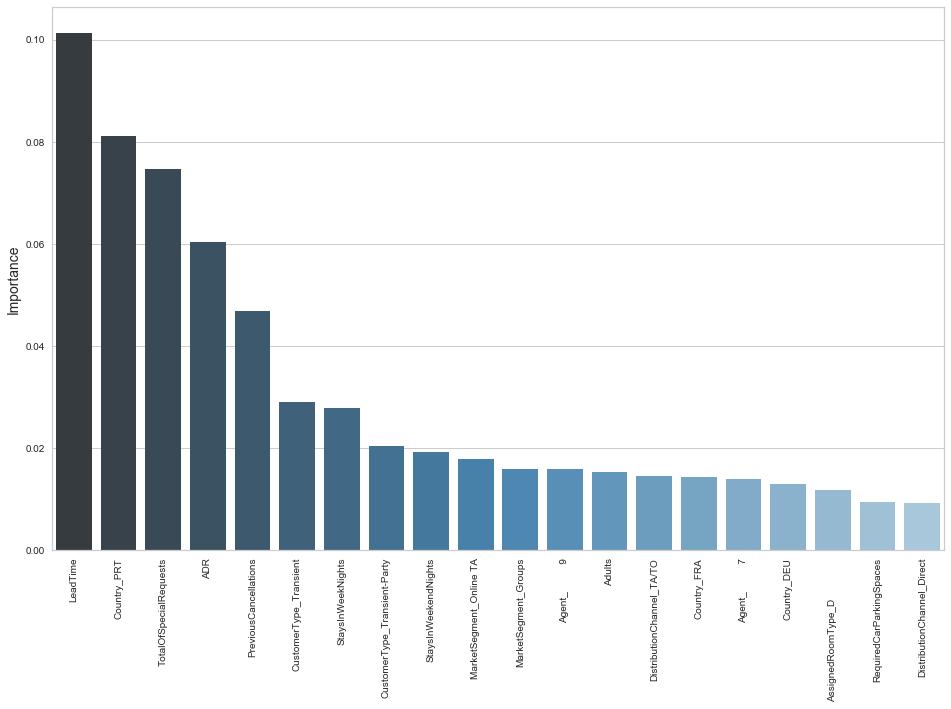

In [226]:
plt.figure(figsize=(16,10))
sns.barplot(x='Feature', y='Importance', data=top_20_features, palette="Blues_d")
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel('Importance', fontsize=14)
plt.show()

## Threshold Selection

In [233]:
df['IsCanceled'].value_counts()

0    46226
1    33076
Name: IsCanceled, dtype: int64

In [286]:
prev = round(33076/(33076+46226),4)
prev

0.4171

In [287]:
TP_cost = 50-30
FP_cost = -20
TN_cost = 0
FN_cost = 0

In [288]:
m = 0.9317

In [289]:
final_model = RandomForestClassifier(max_depth=50, min_samples_leaf=1, n_jobs=1)

In [290]:
final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [291]:
val_prob = final_model.predict_proba(X_val)[:,1]

In [292]:
len(val_prob)

14869

In [293]:
fpr, tpr, thresh = roc_curve(y_val, val_prob)

In [294]:
df_roc = pd.DataFrame()

In [295]:
df_roc['fpr'] = fpr
df_roc['tpr'] = tpr
df_roc['thresh'] = thresh

In [296]:
for i in df_roc.index:
    df_roc.loc[i, 'fm'] = df_roc.loc[i, 'tpr'] - (m * df_roc.loc[i, 'fpr'])

In [297]:
df_roc.sort_values(by='fm', ascending=False, inplace=True)

In [298]:
df_roc.head()

,fpr,tpr,thresh,fm
1777,0.104466,0.859370,0.426710,0.762039
1775,0.104351,0.859208,0.426867,0.761984
1773,0.104236,0.859045,0.426989,0.761928
1776,0.104466,0.859208,0.426720,0.761877
1771,0.104121,0.858883,0.427032,0.761873
